In [115]:
from data_loader import load_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
%matplotlib inline

# Pre-processing:
from sklearn.utils import resample
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint
from sklearn.metrics import classification_report, accuracy_score
import joblib

# Ml models:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier



import warnings
warnings.filterwarnings(action="ignore")


# 1. Load the data from the `data_loader`:

In [2]:
df = load_data()
df.head(1)

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No


## 2. EDA:

## 2.1 Data dimension:

In [3]:
print(f"There are a total of: {df.shape[0]} samples and {df.shape[1]} features in this data.")

There are a total of: 7043 samples and 21 features in this data.


`customer_id` won't be relevant for us, so we will drop it now.

In [4]:
df = df.drop(columns=['customer_id'])

In [5]:
df.shape

(7043, 20)

## 2.2 Check for NULL values:

In [6]:
df.isna().sum()

gender               0
senior_citizen       0
partner              0
dependents           0
tenure               0
phone_service        0
multiple_lines       0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
contract             0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
churn                0
dtype: int64

We don't have any missing values.

## 2.3 Data info:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   gender             7043 non-null   object
 1   senior_citizen     7043 non-null   int64 
 2   partner            7043 non-null   object
 3   dependents         7043 non-null   object
 4   tenure             7043 non-null   int64 
 5   phone_service      7043 non-null   object
 6   multiple_lines     7043 non-null   object
 7   internet_service   7043 non-null   object
 8   online_security    7043 non-null   object
 9   online_backup      7043 non-null   object
 10  device_protection  7043 non-null   object
 11  tech_support       7043 non-null   object
 12  streaming_tv       7043 non-null   object
 13  streaming_movies   7043 non-null   object
 14  contract           7043 non-null   object
 15  paperless_billing  7043 non-null   object
 16  payment_method     7043 non-null   object


There are some changes we need to do for the `dtypes`.

In [8]:
df['senior_citizen'] = df['senior_citizen'].astype('object')
df['monthly_charges'] = df['monthly_charges'].astype('float64')
df['total_charges'] = df['total_charges'].astype('float64')

In [9]:
df['churn'] = df['churn'].map({"Yes": 1, "No":0})

In [10]:
df.head(1)

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0


## 2.4 Data Exploration with Visualization:

It is important to understand the data distribution and most importantly for a classification task i.e. whehter a customer will Churn `1` or Not-Churn `0`, we need to see if we have class imabalance or not. It is quite common to have a class imbalance problem, where the count of one class is higher than the other, which might create problem when building the model. It will create a bias.

### Univariate Analysis:

#### Churn:

In [11]:
df['churn'].value_counts()

churn
0    5174
1    1869
Name: count, dtype: int64

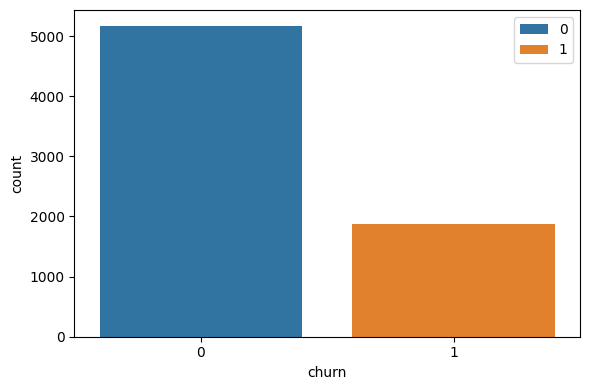

In [12]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='churn', hue='churn')
plt.legend()
plt.tight_layout()
plt.show()

The dataset is imbalanced, `class 0` is dominating the count.

When training the model in the later stage, I will use two versions of dataset:
1. This normal imbalanced dataset.
2. A balanced dataset which will be handled using `Oversampling technique`.

And then compare the results and choose the data accordingly but use of imbalanced data will most defnitely create the problem, so lets find out later on.

Now, i will use a resample technique and handle the class imbalance and keep this data set separately to try out at the later stage.

#### Handling class imbalance:

In [13]:
majority_class = df[df['churn'] == 0]
minorty_class = df[df['churn'] == 1]

minority_oversampled = resample(minorty_class, replace=True, n_samples=len(majority_class), random_state=42)
df_balanced = pd.concat([majority_class, minority_oversampled])

# To shuffle the data to introduce randomness:
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

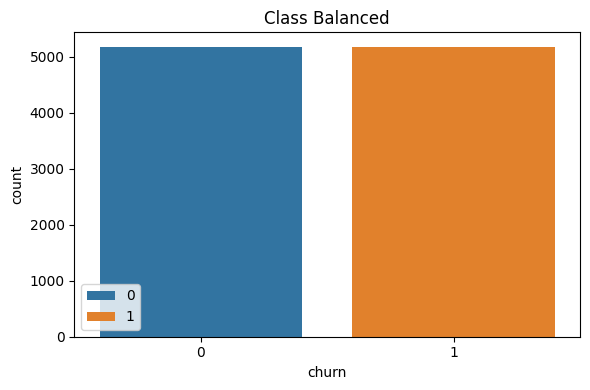

In [14]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_balanced, x='churn', hue='churn')
plt.title("Class Balanced")
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [15]:
df_balanced.shape

(10348, 20)

Now, we have a balanced dataset.

#### Numerical Features:

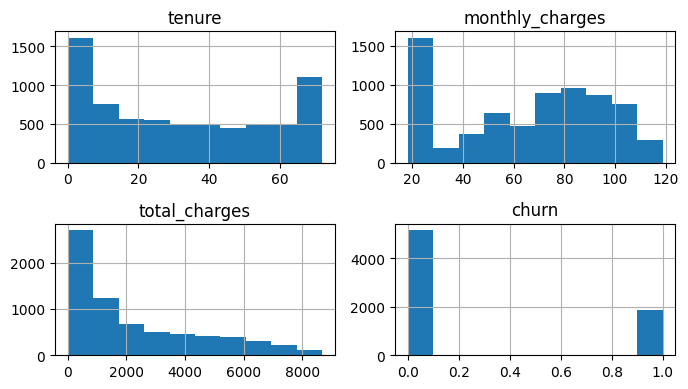

In [16]:
df.hist(figsize=(7, 4))
plt.tight_layout()
plt.show()

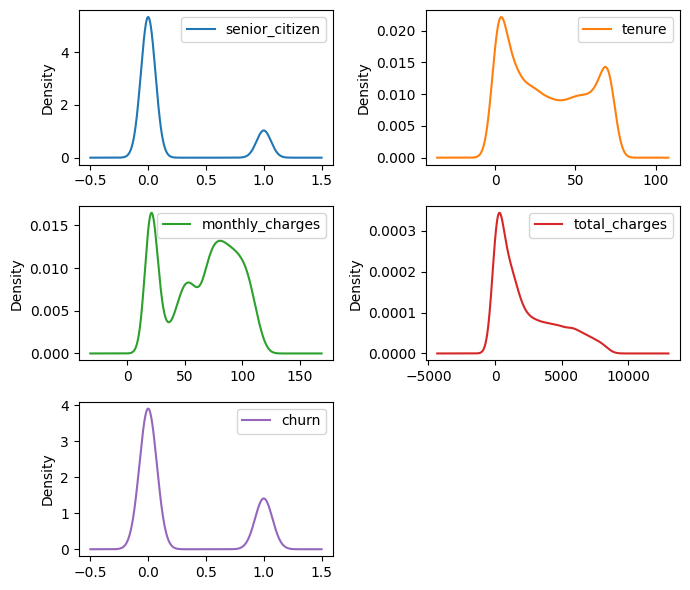

In [17]:
df.plot(kind='density', subplots=True, layout=(3, 2), figsize=(7, 6), sharex=False)
plt.tight_layout()
plt.show()

We can see that most of the clients are young.

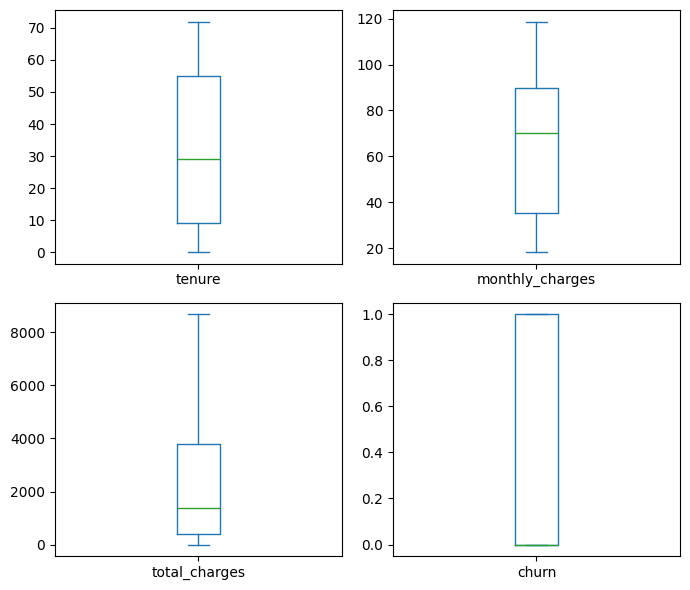

In [18]:
df.plot(kind='box', subplots=True, layout=(2, 2), figsize=(7, 6))
plt.tight_layout()
plt.show()

#### Gender:

Customer involvement by gender:

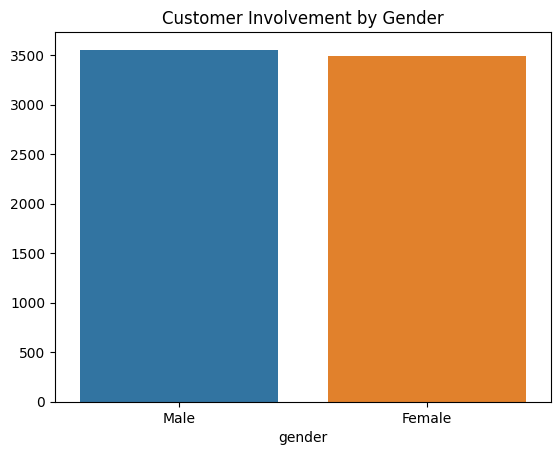

In [19]:
sns.barplot(x=df['gender'].value_counts().index, 
            y=df['gender'].value_counts().values, 
            hue=df['gender'].value_counts().index)
plt.title("Customer Involvement by Gender")
plt.show()

#### Contract:

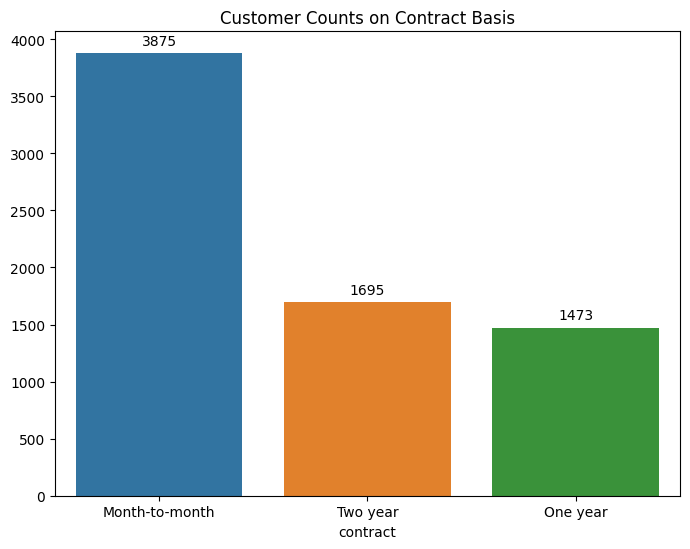

In [20]:
plt.figure(figsize=(7, 5.6))
ax = sns.barplot(x=df['contract'].value_counts().index,
                 y=df['contract'].value_counts().values,
                 hue=df['contract'].value_counts().index
                )


for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 9), textcoords='offset points')

plt.title("Customer Counts on Contract Basis")
plt.tight_layout()
plt.show()

This dataset has no any date columns else we could assume how long they have been in the business. If it has been for a short time then this chart shows the company is doing well as the contract for one year and two years are there which shows some level of trust and satisfaction but if the company is old then we need to come up with some strategies to turn customers from month-to-month subscription ot one or more year contract.

#### Tenure:

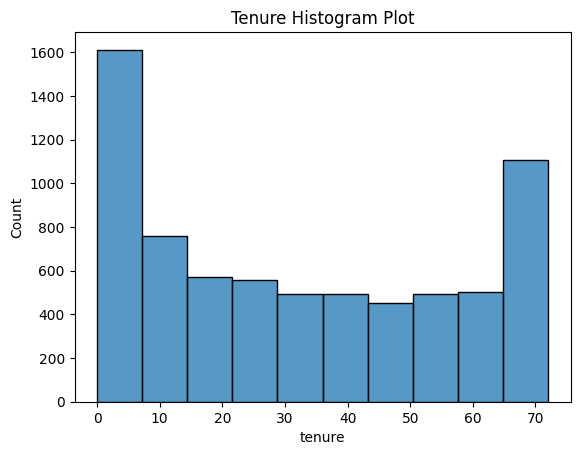

In [21]:
sns.histplot(df['tenure'], bins=10)
plt.title("Tenure Histogram Plot")
plt.show()

Here, is an interesting pattern, there are customers who have been with the company for past 70 months, and there are new batch of customer who are at their first experience ranging from their first to their fifth month of subscription. So, this shows, the company has been running their services for a long time and clears out doubt for earlier chart.

#### Customer Marriage Status:

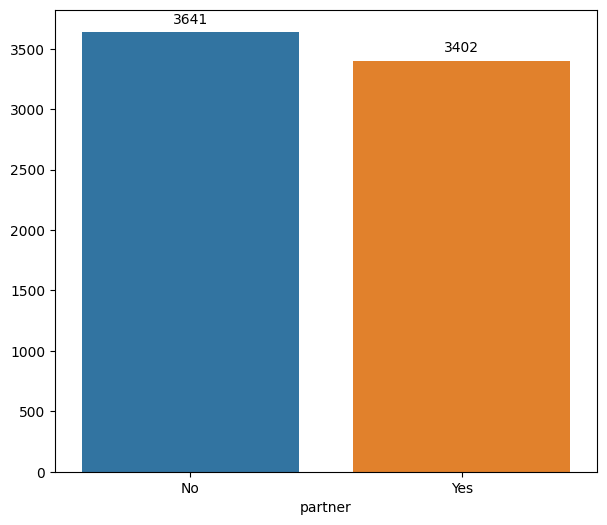

In [22]:
plt.figure(figsize=(7, 6))
ax = sns.barplot(x=df['partner'].value_counts().index,
                y=df['partner'].value_counts().values,
                hue=df['partner'].value_counts().index)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 9), textcoords='offset points')
    
plt.show()

# 3. Data Pre-processing:

In the categorical data that we have, there is no any Ordinal data, and these categorical columns also don't have too much of cardinality, so, here I will be using `One-hot Encoding`.

In [23]:
def data_encoding(df):
    X = df.iloc[:, 0:-1]
    y = df.iloc[:, -1].astype(int)
    numerical_df = X.select_dtypes(include=['int64', 'float64'])
    
    categorical_df = X.select_dtypes(include=['object'])
    categorical_cols = categorical_df.columns
    transformers = [(col, OneHotEncoder(), [col]) for col in categorical_cols]
    
    column_transformer = ColumnTransformer(transformers=transformers, remainder='passthrough')
    encoded_data = column_transformer.fit_transform(X)
    encoded_df = pd.DataFrame(encoded_data, columns=column_transformer.get_feature_names_out())
    
    
    return encoded_df, y, numerical_df

In [24]:
X, y, numerical_df = data_encoding(df)

In [25]:
X_balanced, y_balanced, numerical_df_balanced = data_encoding(df_balanced)

Here, I have encoded both, the original imbalanced and the balanced dataset. And numerical data has been separated for correlation and Mult-collinearity:

# 4. Correlation and Multi-Collinearity:

## 4.1 Correlation:

In [26]:
numerical_df = pd.concat([numerical_df, y], axis=1)
numerical_df_balanced = pd.concat([numerical_df_balanced, y], axis=1)

In [27]:
data_corr1 = numerical_df.corr()
data_corr2 = numerical_df_balanced.corr()

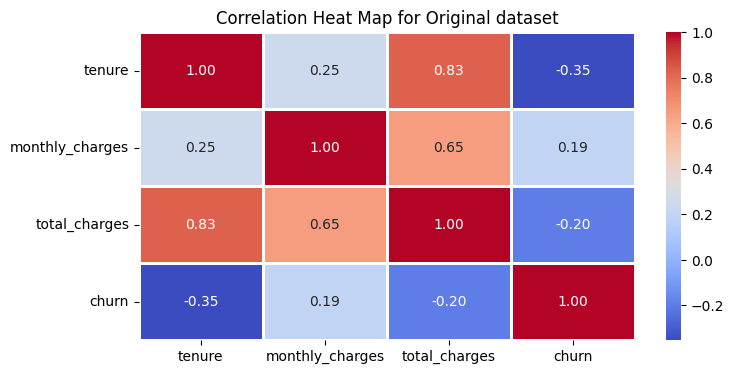

In [28]:
plt.figure(figsize=(8, 4))
sns.heatmap(data_corr1, annot=True, fmt='.2f', linewidths=0.75, cmap='coolwarm')
plt.title('Correlation Heat Map for Original dataset')
plt.show()

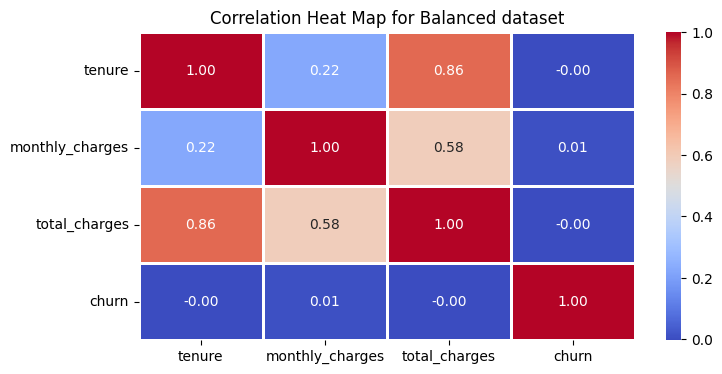

In [29]:
plt.figure(figsize=(8, 4))
sns.heatmap(data_corr2, annot=True, fmt='.2f', linewidths=0.75, cmap='coolwarm')
plt.title('Correlation Heat Map for Balanced dataset')
plt.show()

In the balanced dataset, the correlation seems strong may be because now the classes are balanced. But let's see how it goes.

## 4.2 Multi-Collinearity (VIF):

In [30]:
numerical_df = numerical_df.drop(columns='churn')
numerical_df_balanced = numerical_df_balanced.drop(columns='churn')

In [31]:
vif_data = pd.DataFrame()
vif_data["feature"] = numerical_df.columns
vif_data["VIF"] = [variance_inflation_factor(numerical_df.values, i) for i in range(numerical_df.shape[1])]

vif_data

,feature,VIF
0,tenure,6.332328
1,monthly_charges,3.355660
2,total_charges,8.075070


There is no any feature that has VIF above the threshold of 10, else it would be considered having `Multi-collinearity.`

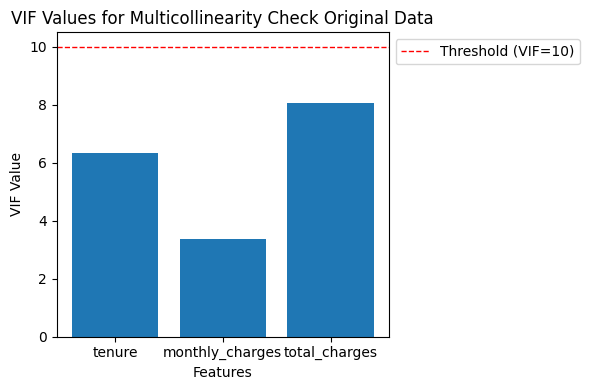

In [32]:
plt.figure(figsize=(6, 4))
plt.bar(x='feature', height='VIF', data=vif_data)
plt.title('VIF values for Mult-collinearity Check')
plt.axhline(y=10, color='red', linestyle='--', linewidth=1, label='Threshold (VIF=10)')
plt.xlabel("Features")
plt.ylabel("VIF Value")
plt.title("VIF Values for Multicollinearity Check Original Data")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [33]:
vif_data = pd.DataFrame()
vif_data["feature"] = numerical_df_balanced.columns
vif_data["VIF"] = [variance_inflation_factor(numerical_df_balanced.values, i) for i in range(numerical_df_balanced.shape[1])]

vif_data

,feature,VIF
0,tenure,7.051228
1,monthly_charges,2.745994
2,total_charges,8.305718


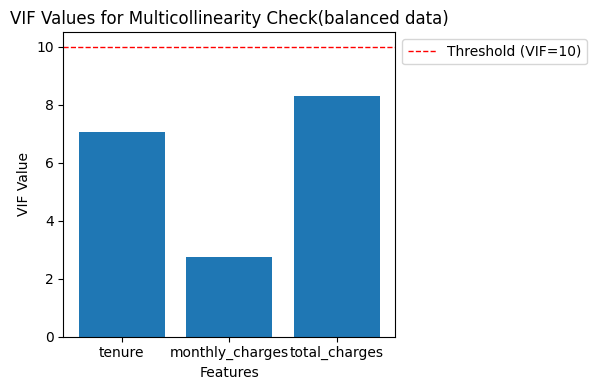

In [34]:
plt.figure(figsize=(6, 4))
plt.bar(x='feature', height='VIF', data=vif_data)
plt.title('VIF values for Mult-collinearity Check')
plt.axhline(y=10, color='red', linestyle='--', linewidth=1, label='Threshold (VIF=10)')
plt.xlabel("Features")
plt.ylabel("VIF Value")
plt.title("VIF Values for Multicollinearity Check(balanced data)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# 5. Spot Checking Algorithms:

Sometimes the model might perform well on the data that is not scaled and sometimes not, so here, I will be Spot checking some classification models on both, scaled and unscaled data.

## 5.1 Original dataset:

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Unscaled data:

In [36]:
models = []

models.append(('LR', LogisticRegression(class_weight='balanced', max_iter=3000)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('NB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier()))

In [37]:
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=7)
    cv_results = cross_validate(model, X_train, y_train, cv=kfold,scoring=['accuracy', 'precision', 'recall', 'f1'])
    
    results.append({
        'name': name,
        'accuracy': cv_results['test_accuracy'].mean(),
        'precision': cv_results['test_precision'].mean(),
        'recall': cv_results['test_recall'].mean(),
        'f1': cv_results['test_f1'].mean()
    })
    
    names.append(name)

    
    print(f"{name}: Mean Accuracy: {cv_results['test_accuracy'].mean():.4f}, "
          f"Precision: {cv_results['test_precision'].mean():.4f}, "
          f"Recall: {cv_results['test_recall'].mean():.4f}, "
          f"F1 Score: {cv_results['test_f1'].mean():.4f}")

LR: Mean Accuracy: 0.7478, Precision: 0.5163, Recall: 0.7939, F1 Score: 0.6254
LDA: Mean Accuracy: 0.7959, Precision: 0.6335, Recall: 0.5492, F1 Score: 0.5877
CART: Mean Accuracy: 0.7196, Precision: 0.4738, Recall: 0.4869, F1 Score: 0.4788
SVM: Mean Accuracy: 0.7346, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
NB: Mean Accuracy: 0.6933, Precision: 0.4582, Recall: 0.8431, F1 Score: 0.5934
KNN: Mean Accuracy: 0.7638, Precision: 0.5704, Recall: 0.4574, F1 Score: 0.5064


These `F1-score` are not so good and `SVM` gave 0 which shows how sensitive is it to unscaled data.

### Scaled Data:

In [38]:
pipelines = []

pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())])))

pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()),                                         
                                        ('LDA', LinearDiscriminantAnalysis())])))

pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),                                          
                                         ('CART', DecisionTreeClassifier())])))

pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),                                         
                                        ('SVM', SVC())])))

pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),                                        
                                       ('NB', GaussianNB())])))

pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),
                                        ('KNN', KNeighborsClassifier())])))

In [39]:
results = []
names = []

for name, model in pipelines:
    kfold = KFold(n_splits=10, shuffle=True, random_state=7)
    cv_result = cross_validate(model, X_train, y_train, cv=kfold, scoring=['accuracy', 'precision', 'recall', 'f1'])
    
    results.append({
        'name': name,
        'accuracy': cv_results['test_accuracy'].mean(),
        'precision': cv_results['test_precision'].mean(),
        'recall': cv_results['test_recall'].mean(),
        'f1': cv_results['test_f1'].mean()
    })
    
    names.append(name)

    
    print(f"{name}: Mean Accuracy: {cv_results['test_accuracy'].mean():.4f}, "
          f"Precision: {cv_results['test_precision'].mean():.4f}, "
          f"Recall: {cv_results['test_recall'].mean():.4f}, "
          f"F1 Score: {cv_results['test_f1'].mean():.4f}")

ScaledLR: Mean Accuracy: 0.7638, Precision: 0.5704, Recall: 0.4574, F1 Score: 0.5064
ScaledLDA: Mean Accuracy: 0.7638, Precision: 0.5704, Recall: 0.4574, F1 Score: 0.5064
ScaledCART: Mean Accuracy: 0.7638, Precision: 0.5704, Recall: 0.4574, F1 Score: 0.5064
ScaledSVM: Mean Accuracy: 0.7638, Precision: 0.5704, Recall: 0.4574, F1 Score: 0.5064
ScaledNB: Mean Accuracy: 0.7638, Precision: 0.5704, Recall: 0.4574, F1 Score: 0.5064
ScaledKNN: Mean Accuracy: 0.7638, Precision: 0.5704, Recall: 0.4574, F1 Score: 0.5064


`SVM` went from 0 to 0.566 on Scaled-data.

### Ensemble Models:

Enesemble models are robust to unscaled data, so I wont't be scaling the data here.

In [40]:
ensembles = [
    ('AB', AdaBoostClassifier()),
    ('GBM', GradientBoostingClassifier()),
    ('RF', RandomForestClassifier()),
    ('ET', ExtraTreesClassifier(class_weight='balanced'))
]


results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)  
    cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=['accuracy', 'precision', 'recall', 'f1'])

    
    results.append({
        'name': name,
        'accuracy': cv_results['test_accuracy'].mean(),
        'precision': cv_results['test_precision'].mean(),
        'recall': cv_results['test_recall'].mean(),
        'f1': cv_results['test_f1'].mean()
    })
    
    names.append(name)

    
    print(f"{name}: Mean Accuracy: {cv_results['test_accuracy'].mean():.4f}, "
          f"Precision: {cv_results['test_precision'].mean():.4f}, "
          f"Recall: {cv_results['test_recall'].mean():.4f}, "
          f"F1 Score: {cv_results['test_f1'].mean():.4f}")





AB: Mean Accuracy: 0.8044, Precision: 0.6655, Recall: 0.5236, F1 Score: 0.5859
GBM: Mean Accuracy: 0.8014, Precision: 0.6562, Recall: 0.5256, F1 Score: 0.5831
RF: Mean Accuracy: 0.7867, Precision: 0.6276, Recall: 0.4799, F1 Score: 0.5431
ET: Mean Accuracy: 0.7709, Precision: 0.5837, Recall: 0.4721, F1 Score: 0.5211


#### Still no any good results, so now, lets move into the balanced dataset that was achieved using oversampling.

## 5.2 Balanced Dataset:

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, 
                                                    test_size=0.2, random_state=42, 
                                                    stratify=y_balanced)

### Unscaled Data:

In [42]:
models = []

models.append(('LR', LogisticRegression(class_weight='balanced', max_iter=3000)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('NB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier()))

In [43]:
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=7)
    cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=['accuracy', 'precision', 'recall', 'f1'])
    
    results.append({
        'name': name,
        'accuracy': cv_results['test_accuracy'].mean(),
        'precision': cv_results['test_precision'].mean(),
        'recall': cv_results['test_recall'].mean(),
        'f1': cv_results['test_f1'].mean()
    })
    
    names.append(name)

    
    print(f"{name}: Mean Accuracy: {cv_results['test_accuracy'].mean():.4f}, "
          f"Precision: {cv_results['test_precision'].mean():.4f}, "
          f"Recall: {cv_results['test_recall'].mean():.4f}, "
          f"F1 Score: {cv_results['test_f1'].mean():.4f}")

LR: Mean Accuracy: 0.7672, Precision: 0.7501, Recall: 0.8015, F1 Score: 0.7748
LDA: Mean Accuracy: 0.7612, Precision: 0.7426, Recall: 0.7997, F1 Score: 0.7700
CART: Mean Accuracy: 0.8662, Precision: 0.8212, Recall: 0.9361, F1 Score: 0.8748
SVM: Mean Accuracy: 0.6480, Precision: 0.6725, Recall: 0.5769, F1 Score: 0.6209
NB: Mean Accuracy: 0.7351, Precision: 0.6912, Recall: 0.8497, F1 Score: 0.7622
KNN: Mean Accuracy: 0.7530, Precision: 0.7230, Recall: 0.8202, F1 Score: 0.7684


### Scaled Data:

In [44]:
pipelines = []

pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())])))

pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()),                                         
                                        ('LDA', LinearDiscriminantAnalysis())])))

pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),                                          
                                         ('CART', DecisionTreeClassifier())])))

pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),                                         
                                        ('SVM', SVC())])))

pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),                                        
                                       ('NB', GaussianNB())])))

pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),
                                        ('KNN', KNeighborsClassifier())])))

In [45]:
results = []
names = []

for name, model in pipelines:
    kfold = KFold(n_splits=10, shuffle=True, random_state=7)
    cv_result = cross_validate(model, X_train, y_train, cv=kfold, scoring=['accuracy', 'precision', 'recall', 'f1'])
    
    
    results.append({
        'name': name,
        'accuracy': cv_results['test_accuracy'].mean(),
        'precision': cv_results['test_precision'].mean(),
        'recall': cv_results['test_recall'].mean(),
        'f1': cv_results['test_f1'].mean()
    })
    
    names.append(name)

    
    print(f"{name}: Mean Accuracy: {cv_results['test_accuracy'].mean():.4f}, "
          f"Precision: {cv_results['test_precision'].mean():.4f}, "
          f"Recall: {cv_results['test_recall'].mean():.4f}, "
          f"F1 Score: {cv_results['test_f1'].mean():.4f}")

ScaledLR: Mean Accuracy: 0.7530, Precision: 0.7230, Recall: 0.8202, F1 Score: 0.7684
ScaledLDA: Mean Accuracy: 0.7530, Precision: 0.7230, Recall: 0.8202, F1 Score: 0.7684
ScaledCART: Mean Accuracy: 0.7530, Precision: 0.7230, Recall: 0.8202, F1 Score: 0.7684
ScaledSVM: Mean Accuracy: 0.7530, Precision: 0.7230, Recall: 0.8202, F1 Score: 0.7684
ScaledNB: Mean Accuracy: 0.7530, Precision: 0.7230, Recall: 0.8202, F1 Score: 0.7684
ScaledKNN: Mean Accuracy: 0.7530, Precision: 0.7230, Recall: 0.8202, F1 Score: 0.7684


### Ensemble Models:

In [46]:
ensembles = [
    ('AB', AdaBoostClassifier()),
    ('GBM', GradientBoostingClassifier()),
    ('RF', RandomForestClassifier()),
    ('ET', ExtraTreesClassifier(class_weight='balanced'))
]


results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)  
    cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=['accuracy', 'precision', 'recall', 'f1'])

    
    results.append({
        'name': name,
        'accuracy': cv_results['test_accuracy'].mean(),
        'precision': cv_results['test_precision'].mean(),
        'recall': cv_results['test_recall'].mean(),
        'f1': cv_results['test_f1'].mean()
    })
    
    names.append(name)

    
    print(f"{name}: Mean Accuracy: {cv_results['test_accuracy'].mean():.4f}, "
          f"Precision: {cv_results['test_precision'].mean():.4f}, "
          f"Recall: {cv_results['test_recall'].mean():.4f}, "
          f"F1 Score: {cv_results['test_f1'].mean():.4f}")





AB: Mean Accuracy: 0.7716, Precision: 0.7492, Recall: 0.8168, F1 Score: 0.7814
GBM: Mean Accuracy: 0.7920, Precision: 0.7706, Recall: 0.8318, F1 Score: 0.7999
RF: Mean Accuracy: 0.8964, Precision: 0.8577, Recall: 0.9507, F1 Score: 0.9017
ET: Mean Accuracy: 0.9006, Precision: 0.8711, Recall: 0.9405, F1 Score: 0.9044


The best results so far are from the `Ensemble models.`

### Scaled on Ensemble Models:

In [47]:
ensemble_scaled = []

ensemble_scaled.append(('ScaledADABoost', Pipeline([('Scaler', StandardScaler()),
                                       ('AB', AdaBoostClassifier())])))

ensemble_scaled.append(('ScaledGBC', Pipeline([('Scaler', StandardScaler()),                                         
                                        ('GBC', GradientBoostingClassifier())])))

ensemble_scaled.append(('ScaledRFC', Pipeline([('Scaler', StandardScaler()),                                          
                                         ('RFC', RandomForestClassifier(class_weight='balanced'))])))

ensemble_scaled.append(('ScaledETC', Pipeline([('Scaler', StandardScaler()),
                                        ('ETC', ExtraTreesClassifier(class_weight='balanced'))])))

In [48]:
results = []
names = []
for name, model in ensemble_scaled:
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)  
    cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=['accuracy', 'precision', 'recall', 'f1'])

    
    results.append({
        'name': name,
        'accuracy': cv_results['test_accuracy'].mean(),
        'precision': cv_results['test_precision'].mean(),
        'recall': cv_results['test_recall'].mean(),
        'f1': cv_results['test_f1'].mean()
    })
    
    names.append(name)

    
    print(f"{name}: Mean Accuracy: {cv_results['test_accuracy'].mean():.4f}, "
          f"Precision: {cv_results['test_precision'].mean():.4f}, "
          f"Recall: {cv_results['test_recall'].mean():.4f}, "
          f"F1 Score: {cv_results['test_f1'].mean():.4f}")

ScaledADABoost: Mean Accuracy: 0.7716, Precision: 0.7492, Recall: 0.8168, F1 Score: 0.7814
ScaledGBC: Mean Accuracy: 0.7920, Precision: 0.7706, Recall: 0.8318, F1 Score: 0.7999
ScaledRFC: Mean Accuracy: 0.8955, Precision: 0.8552, Recall: 0.9526, F1 Score: 0.9011
ScaledETC: Mean Accuracy: 0.9000, Precision: 0.8713, Recall: 0.9388, F1 Score: 0.9037


Out of these models, now, I will be moving forward with the `ExtraTreesClassifier` and `RandomForest`. The data won't be scaled because there is much difference so better not to keep extra loads of scaling and I will be using the balanced dataset.

# 6. Hyper-Parameter Optimization:

### 1. Random Forest:

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, 
                                                    test_size=0.2, random_state=42, 
                                                    stratify=y_balanced)

In [50]:
param_dist_rf = {
    'n_estimators': randint(100, 300),  
    'max_depth': [5, 7, 10, 15, 20, 25], 
    'min_samples_split': randint(10, 20),  
    'min_samples_leaf': randint(4, 15),    
    'class_weight': ['balanced'],
    'max_features': ['sqrt', 'log2'] 
}

In [51]:
random_forest_clf = RandomForestClassifier()

folds = KFold(n_splits=10, shuffle=True, random_state=7)
randomized_search = RandomizedSearchCV(estimator=random_forest_clf, param_distributions=param_dist_rf, 
                                       n_iter=15, scoring='f1', cv=folds, random_state=42, n_jobs=-1)

randomized_search.fit(X_train, y_train)

best_params_rf = randomized_search.best_params_
print("Best parameters found:", best_params_rf)

Best parameters found: {'class_weight': 'balanced', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 19, 'n_estimators': 121}


In [52]:
random_forest_clf = RandomForestClassifier(**best_params_rf)
random_forest_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=4, min_samples_split=19,
                       n_estimators=121)

In [53]:
y_train_pred = random_forest_clf.predict(X_train)
y_test_pred = random_forest_clf.predict(X_test)

In [54]:
accuracy_score(y_train, y_train_pred)

0.8709833293065958

In [55]:
accuracy_score(y_test, y_test_pred)

0.8227053140096618

There is a bit of overfitting.

### 2. ExtraTreesClassifier:

In [56]:
param_dist_et = {
    'n_estimators': randint(100, 350),
    'max_depth': [5, 10, 15, 20],  
    'min_samples_split': randint(15, 30), 
    'min_samples_leaf': randint(8, 25),  
    'class_weight': ['balanced'],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False] 
}

et_clf = ExtraTreesClassifier()

folds = KFold(n_splits=10, shuffle=True, random_state=7)
randomized_search = RandomizedSearchCV(estimator=et_clf, param_distributions=param_dist_et, 
                                       n_iter=15, scoring='f1', cv=folds, random_state=42, n_jobs=-1)

randomized_search.fit(X_train, y_train)

best_params_et = randomized_search.best_params_
print("Best parameters found:", best_params_et)

Best parameters found: {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 13, 'min_samples_split': 16, 'n_estimators': 291}


In [57]:
extra_trees_clf = ExtraTreesClassifier(**best_params_et)
extra_trees_clf.fit(X_train, y_train)

ExtraTreesClassifier(class_weight='balanced', max_depth=20, max_features='log2',
                     min_samples_leaf=13, min_samples_split=16,
                     n_estimators=291)

In [58]:
y_train_pred = extra_trees_clf.predict(X_train)
y_test_pred = extra_trees_clf.predict(X_test)

In [59]:
accuracy_score(y_train, y_train_pred)

0.8151727470403479

In [60]:
accuracy_score(y_test, y_test_pred)

0.7888888888888889

In [61]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.84      0.78      0.81      4139
           1       0.80      0.85      0.82      4139

    accuracy                           0.82      8278
   macro avg       0.82      0.82      0.81      8278
weighted avg       0.82      0.82      0.81      8278



In [62]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.75      0.78      1035
           1       0.77      0.82      0.80      1035

    accuracy                           0.79      2070
   macro avg       0.79      0.79      0.79      2070
weighted avg       0.79      0.79      0.79      2070



In [63]:
best_params_et

{'bootstrap': False,
 'class_weight': 'balanced',
 'max_depth': 20,
 'max_features': 'log2',
 'min_samples_leaf': 13,
 'min_samples_split': 16,
 'n_estimators': 291}

### Using `GridSearchCV`:

In [64]:
param_grid_et = {
    'n_estimators': [150, 200, 250],  
    'max_depth': [10, 15, 20],  
    'min_samples_split': [15, 20],  
    'min_samples_leaf': [10, 13, 15],  
    'class_weight': ['balanced'],
    'max_features': ['log2'],
    'bootstrap': [False] 
}



et_model = ExtraTreesClassifier(random_state=42)


grid_search_et = GridSearchCV(
    estimator=et_model,
    param_grid=param_grid_et,
    scoring='f1',  
    cv=5,  
    verbose=2,  
    n_jobs=-1  
)


grid_search_et.fit(X_train, y_train)


print("Best Parameters:", grid_search_et.best_params_)
best_et_model = grid_search_et.best_estimator_


y_test_pred = best_et_model.predict(X_test)


print(classification_report(y_test, y_test_pred))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 15, 'n_estimators': 250}
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      1035
           1       0.78      0.84      0.81      1035

    accuracy                           0.80      2070
   macro avg       0.80      0.80      0.80      2070
weighted avg       0.80      0.80      0.80      2070



In [74]:
y_train_pred = best_et_model.predict(X_train)
accuracy_score(y_train, y_train_pred)

0.8320850446967867

In [75]:
y_test_pred = best_et_model.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.7990338164251207

In [70]:
et_model_params = best_et_model.get_params()

These are the best Hyper-parameters and results so far. So, the model will be `ExtraTreesClassifier` with these Hyper-parameters.

In [76]:
et_model_params

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 15,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 250,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

# Building the Final Model:

#### Load and clean some data types:

In [79]:
df = load_data()

In [84]:
df.head(1)

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No


In [85]:
df = df.drop(columns=['customer_id'])

In [87]:
df['senior_citizen'] = df['senior_citizen'].astype('object')

In [89]:
df['monthly_charges'] = df['monthly_charges'].astype('float64')
df['total_charges'] = df['total_charges'].astype('float64')

In [91]:
df['churn'] = df['churn'].map({"Yes":1, "No":0})

#### Build the pipeline to avoid data leakage:

In [99]:
categorical_cols = df.select_dtypes(include='object').columns.to_list()

In [102]:
column_transformer = ColumnTransformer(
    transformers=[
        ('encoding', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', column_transformer),
    ('model', ExtraTreesClassifier(**et_model_params))
])

In [104]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [107]:
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'senior_citizen',
                                                   'partner', 'dependents',
                                                   'phone_service',
                                                   'multiple_lines',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'contract',
                                                   'paperless_billing',
                                                   'payment_method'])])),
                ('model',
                 ExtraTreesClassifier(class_weight='balanced', max_depth=20,
                                      max_features='log2', min_samples_leaf=10,
                                      min_samples_split=15, n_estimators=250,
                                      random_state=42))])

In [111]:
pipeline.predict(X[:4])

array([1, 0, 1, 0], dtype=int64)

In [112]:
y[:4]

0    0
1    0
2    1
3    0
Name: churn, dtype: int64

# Save the model:

In [118]:
joblib.dump(pipeline, "churn_clf_model.pkl")

['churn_clf_model.pkl']